In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.visualization import simple_norm
import ccdproc as ccdp
from ccdproc import subtract_bias

In [2]:
DEBUG = False

if not DEBUG:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger

    warnings.simplefilter('ignore', FITSFixedWarning)
    warnings.simplefilter('ignore', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.ERROR)
else:
    import warnings
    import logging
    from astropy.wcs import FITSFixedWarning
    from astropy.io.fits.verify import VerifyWarning
    from astropy import logger
    
    warnings.simplefilter('default', FITSFixedWarning)
    warnings.simplefilter('default', VerifyWarning)
    logging.getLogger('astropy').setLevel(logging.INFO)

In [3]:
files = ccdp.ImageFileCollection('../data_NGC6888/darks')
files.summary['file', 'imagetyp', 'exptime', 'naxis1', 'naxis2', 'gain', 'egain']

file,imagetyp,exptime,naxis1,naxis2,gain,egain
str30,str10,float64,int64,int64,int64,float64
D_M82_0238_Bin1x1_180s_19C.fit,Dark Frame,180.0,3840,2160,252,0.620981216430664
D_M82_0239_Bin1x1_180s_20C.fit,Dark Frame,180.0,3840,2160,252,0.620981216430664
D_M82_0240_Bin1x1_180s_21C.fit,Dark Frame,180.0,3840,2160,252,0.620981216430664
D_M82_0241_Bin1x1_180s_22C.fit,Dark Frame,180.0,3840,2160,252,0.620981216430664
D_M82_0242_Bin1x1_180s_23C.fit,Dark Frame,180.0,3840,2160,252,0.620981216430664
D_M82_0243_Bin1x1_180s_23C.fit,Dark Frame,180.0,3840,2160,252,0.620981216430664
D_M82_0244_Bin1x1_180s_23C.fit,Dark Frame,180.0,3840,2160,252,0.620981216430664
D_M82_0245_Bin1x1_180s_22C.fit,Dark Frame,180.0,3840,2160,252,0.620981216430664
D_M82_0246_Bin1x1_180s_22C.fit,Dark Frame,180.0,3840,2160,252,0.620981216430664


In [4]:
#копируем файлы из папки data_NGC6888 в папку reduced
parent_dir = Path('..')
calibrated_data = parent_dir / 'reduced'
calibrated_data.mkdir(exist_ok=True)

darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)

import shutil

for dark in darks:
    shutil.copy(dark, calibrated_data)

In [5]:
calibrated_path = Path('../reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

calibrated_darks = reduced_images.files_filtered(imagetyp='Dark Frame', include_path=True)

dark_file = calibrated_darks[0]
dark_ccd = CCDData.read(dark_file, unit='adu') 

dark_data = dark_ccd.data

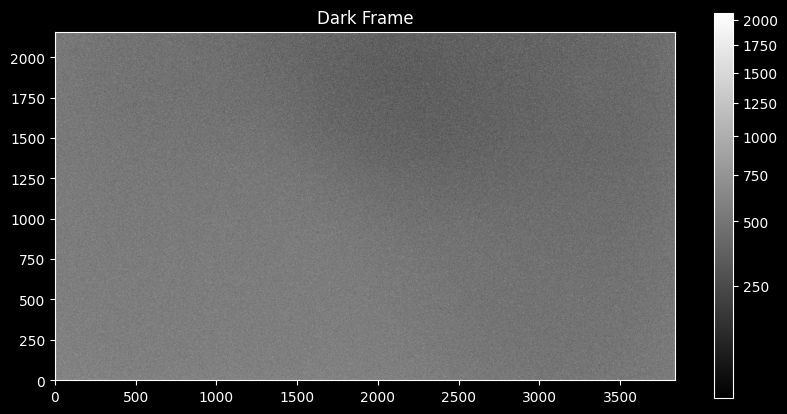

In [6]:
norm = simple_norm(dark_data, stretch='sqrt', percent=99)
plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.imshow(dark_data, cmap='gray', norm=norm, origin='lower')
plt.colorbar()
plt.title('Dark Frame')
plt.show()

Mean: 527.5143209876543
STD: 407.94997678678857
MAD STD: 189.77308396871706


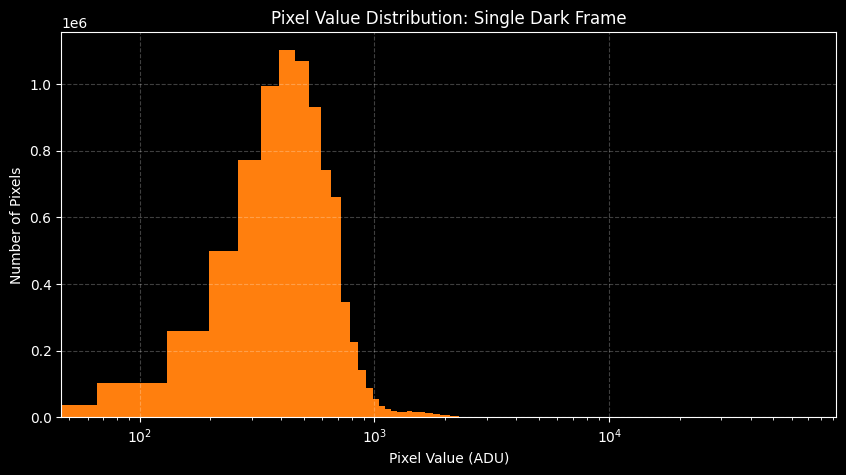

In [7]:
dark_hist = dark_data.flatten()

print(f'Mean: {np.mean(dark_data)}')
print(f'STD: {np.std(dark_data)}')
print(f'MAD STD: {mad_std(dark_data)}')

plt.figure(figsize=(10, 5))
plt.hist(dark_hist, bins=1000, color='tab:orange')
plt.title('Pixel Value Distribution: Single Dark Frame')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.semilogx()
plt.show()

# 1. Just combined dark frames (average + sigma clipping)

In [8]:
combined_dark_avg = ccdp.combine(calibrated_darks,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                                 mem_limit=360e6,
                                 unit='adu')

combined_dark_avg.meta['combined'] = True

combined_dark_avg.write(calibrated_path / 'combined_dark_avg.fit', overwrite=True)

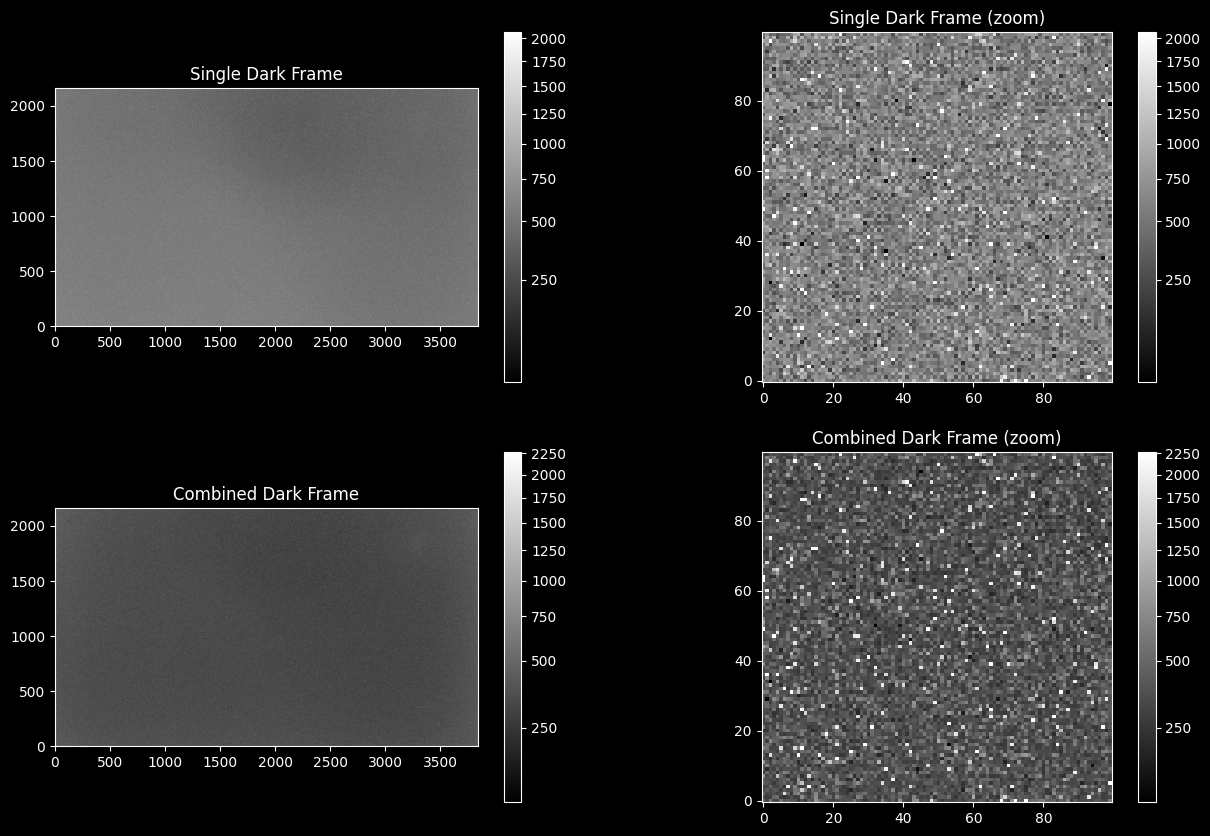

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(dark_data, stretch='sqrt', percent=99)
im1 = ax1.imshow(dark_data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Single Dark Frame')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(dark_data, stretch='sqrt', percent=99)
im2 = ax2.imshow(dark_data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Single Dark Frame (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(combined_dark_avg.data, stretch='sqrt', percent=99)
im3 = ax3.imshow(combined_dark_avg.data, cmap='gray', norm=norm, origin='lower')
ax3.set_title('Combined Dark Frame')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(combined_dark_avg.data, stretch='sqrt', percent=99)
im4 = ax4.imshow(combined_dark_avg.data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Combined Dark Frame (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()


          |  Single Dark Frame  |  Combined Dark Frame  
--------------------------------------------------------
Mean      |        527.51       |         394.17        
STD       |        407.95       |         502.83        
MAD STD   |        189.77       |         96.07         


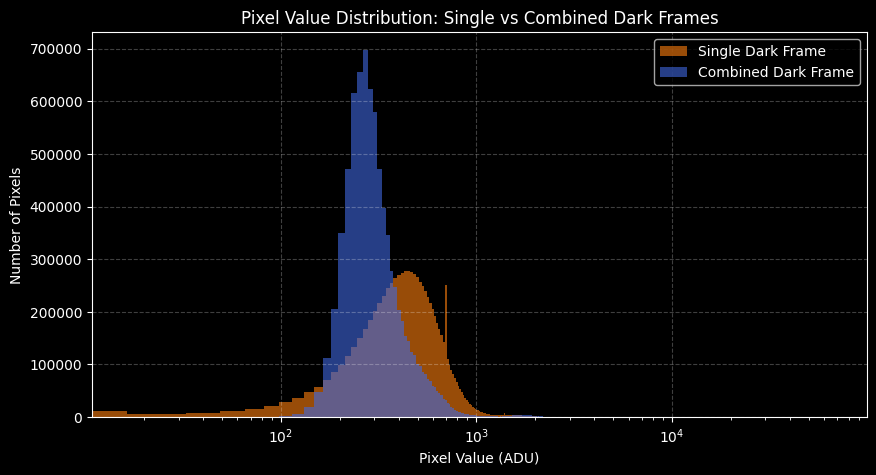

In [10]:
combined_dark_avg_hist = combined_dark_avg.data.flatten()

print(f'{"":<10}| {"Single Dark Frame":^20}| {"Combined Dark Frame":^22}')
print('-' * 56)
print(f'{"Mean":<10}| {np.mean(dark_data):^20.2f}| {np.mean(combined_dark_avg.data):^22.2f}')
print(f'{"STD":<10}| {np.std(dark_data):^20.2f}| {np.std(combined_dark_avg.data):^22.2f}')
print(f'{"MAD STD":<10}| {mad_std(dark_data):^20.2f}| {mad_std(combined_dark_avg.data):^22.2f}')


plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.hist(dark_hist, bins=4000, color='tab:orange', alpha=0.6, label='Single Dark Frame')
plt.hist(combined_dark_avg_hist, bins=4000, color='royalblue', alpha=0.6, label='Combined Dark Frame')
plt.title('Pixel Value Distribution: Single vs Combined Dark Frames')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.legend()
plt.semilogx()
plt.show()

# 2. Subtract the Mater-Bias from each dark frame and combined (average + sigma cliping)

In [11]:
combined_bias = [ccd for ccd in reduced_images.ccds(imagetyp='Bias Frame', combined=True, file='combined_bias_avg.fit')][0]

In [13]:
bias_master = combined_bias  # это CCDData с мастер биасом

# Загрузим каждый дарк и вычтем мастер биас
bias_subtracted_darks = []
for dark_file in calibrated_darks:
    dark_ccd = CCDData.read(dark_file, unit='adu')
    dark_corrected = subtract_bias(dark_ccd, bias_master)
    bias_subtracted_darks.append(dark_corrected)

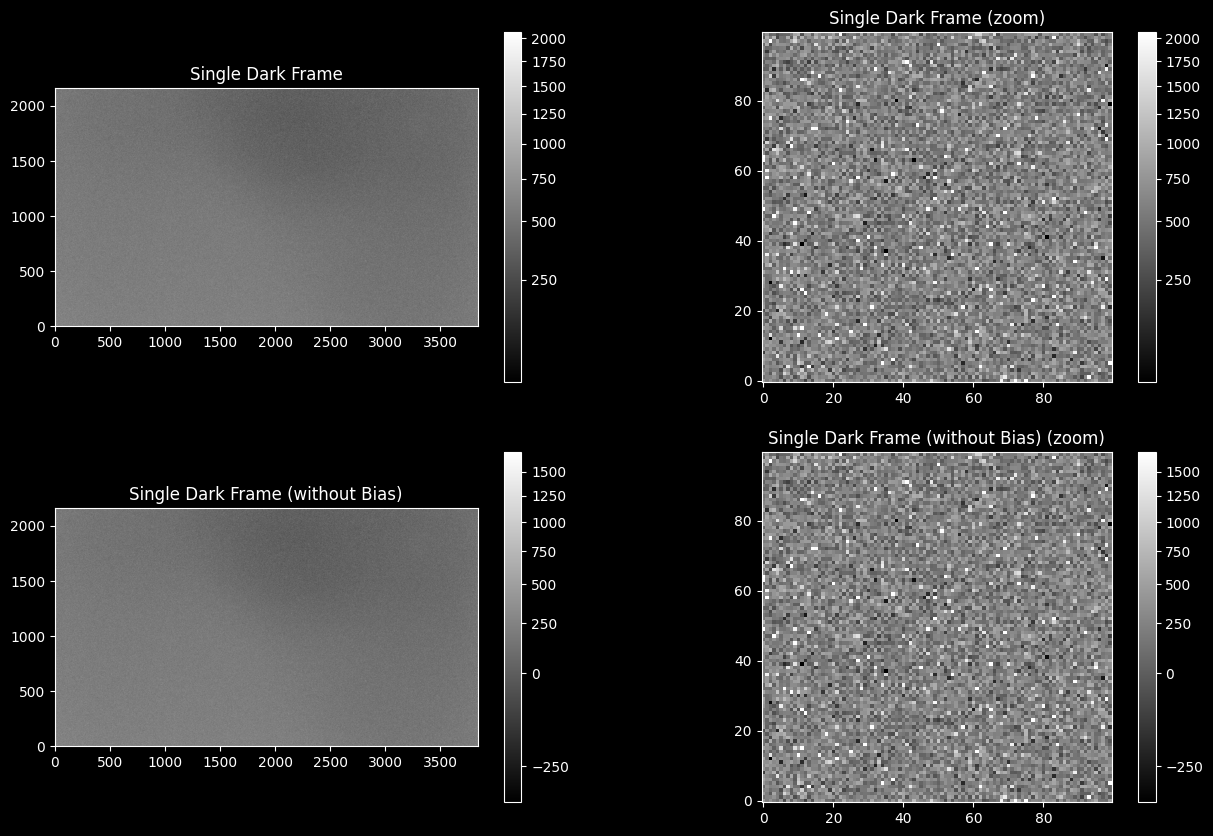

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(dark_data, stretch='sqrt', percent=99)
im1 = ax1.imshow(dark_data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Single Dark Frame')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(dark_data, stretch='sqrt', percent=99)
im2 = ax2.imshow(dark_data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Single Dark Frame (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(bias_subtracted_darks[0], stretch='sqrt', percent=99)
im3 = ax3.imshow(bias_subtracted_darks[0], cmap='gray', norm=norm, origin='lower')
ax3.set_title('Single Dark Frame (without Bias)')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(bias_subtracted_darks[0], stretch='sqrt', percent=99)
im4 = ax4.imshow(bias_subtracted_darks[0][0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Single Dark Frame (without Bias) (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()


          |  Single Dark Frame  | Single Dark Frame (without Bias)
--------------------------------------------------------
Mean      |        527.51       |         180.01        
STD       |        407.95       |         407.90        
MAD STD   |        189.77       |         194.31        


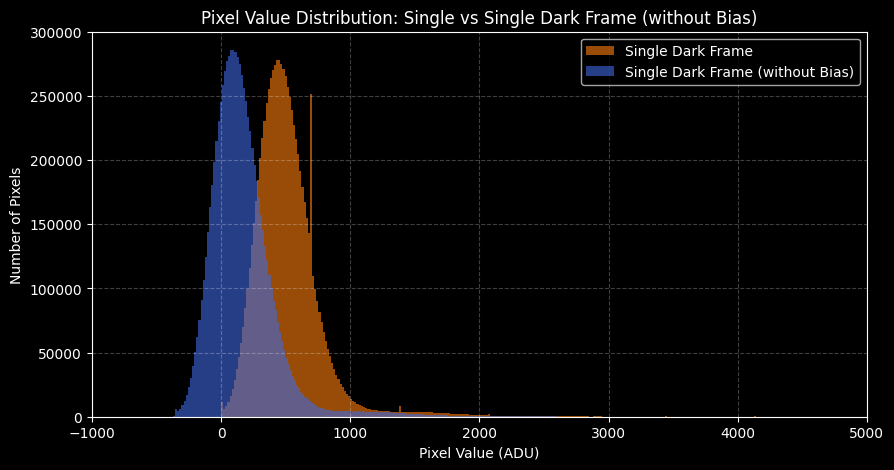

In [16]:
bias_subtracted_darks_hist = bias_subtracted_darks[0].data.flatten()

print(f'{"":<10}| {"Single Dark Frame":^20}| {"Single Dark Frame (without Bias)":^22}')
print('-' * 56)
print(f'{"Mean":<10}| {np.mean(dark_data):^20.2f}| {np.mean(bias_subtracted_darks[0].data):^22.2f}')
print(f'{"STD":<10}| {np.std(dark_data):^20.2f}| {np.std(bias_subtracted_darks[0].data):^22.2f}')
print(f'{"MAD STD":<10}| {mad_std(dark_data):^20.2f}| {mad_std(bias_subtracted_darks[0].data):^22.2f}')


plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.hist(dark_hist, bins=4000, color='tab:orange', alpha=0.6, label='Single Dark Frame')
plt.hist(bias_subtracted_darks_hist, bins=4000, color='royalblue', alpha=0.6, label='Single Dark Frame (without Bias)')
plt.title('Pixel Value Distribution: Single vs Single Dark Frame (without Bias)')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.legend()
plt.xlim(-1000, 5000)
plt.show()

In [18]:
combined_dark_avg_wo_bias = ccdp.combine(bias_subtracted_darks,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                                 mem_limit=360e6,
                                 unit='adu')

combined_dark_avg_wo_bias.meta['combined'] = True

combined_dark_avg_wo_bias.write(calibrated_path / 'combined_dark_avg_wo_bias.fit', overwrite=True)

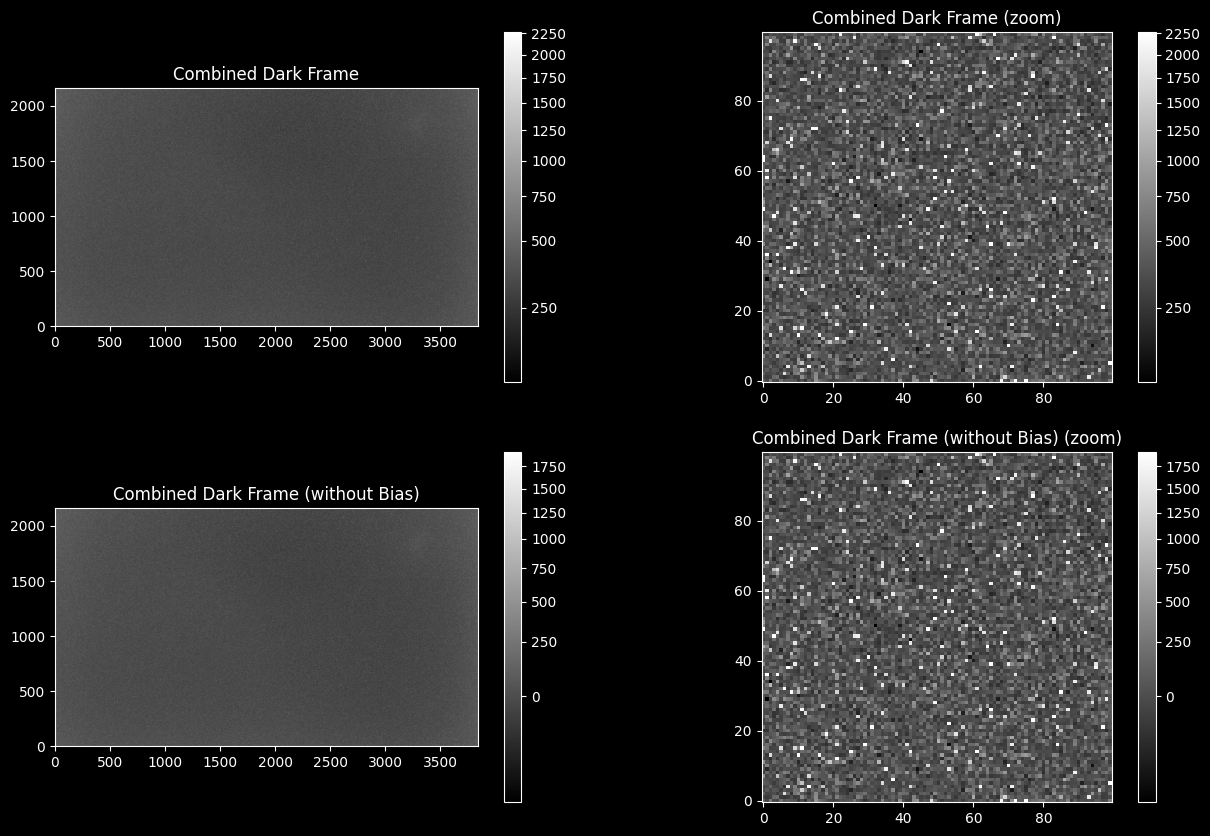

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2, ax3, ax4 = axes.flatten()

norm = simple_norm(combined_dark_avg.data, stretch='sqrt', percent=99)
im1 = ax1.imshow(combined_dark_avg.data, cmap='gray', norm=norm, origin='lower')
ax1.set_title('Combined Dark Frame')
fig.colorbar(im1, ax=ax1)

norm = simple_norm(combined_dark_avg.data, stretch='sqrt', percent=99)
im2 = ax2.imshow(combined_dark_avg.data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax2.set_title('Combined Dark Frame (zoom)')
fig.colorbar(im2, ax=ax2)

norm = simple_norm(combined_dark_avg_wo_bias.data, stretch='sqrt', percent=99)
im3 = ax3.imshow(combined_dark_avg_wo_bias.data, cmap='gray', norm=norm, origin='lower')
ax3.set_title('Combined Dark Frame (without Bias)')
fig.colorbar(im3, ax=ax3)

norm = simple_norm(combined_dark_avg_wo_bias.data, stretch='sqrt', percent=99)
im4 = ax4.imshow(combined_dark_avg_wo_bias.data[0:100, 0:100], cmap='gray', norm=norm, origin='lower')
ax4.set_title('Combined Dark Frame (without Bias) (zoom)')
fig.colorbar(im4, ax=ax4)

plt.show()


          | Combined Dark Frame | Combined Dark Frame (without Bias)
--------------------------------------------------------
Mean      |        394.17       |         46.66         
STD       |        502.83       |         502.84        
MAD STD   |        96.07        |         95.43         


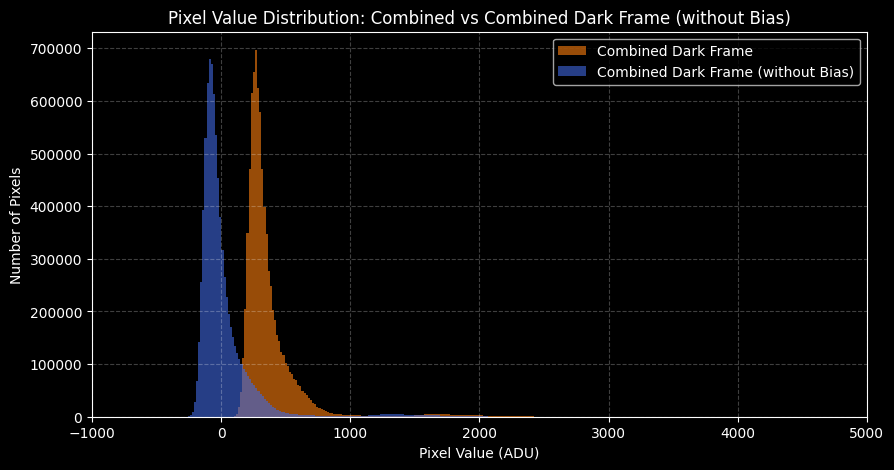

In [ ]:
combined_dark_avg_wo_bias_hist = combined_dark_avg_wo_bias.data.flatten()

print(f'{"":<10}| {"Combined Dark Frame":^20}| {"Combined Dark Frame (without Bias)":^22}')
print('-' * 56)
print(f'{"Mean":<10}| {np.mean(combined_dark_avg.data):^20.2f}| {np.mean(combined_dark_avg_wo_bias.data):^22.2f}')
print(f'{"STD":<10}| {np.std(combined_dark_avg.data):^20.2f}| {np.std(combined_dark_avg_wo_bias.data):^22.2f}')
print(f'{"MAD STD":<10}| {mad_std(combined_dark_avg.data):^20.2f}| {mad_std(combined_dark_avg_wo_bias.data):^22.2f}')


plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.hist(combined_dark_avg_hist, bins=4000, color='tab:orange', alpha=0.6, label='Combined Dark Frame')
plt.hist(combined_dark_avg_wo_bias_hist, bins=4000, color='royalblue', alpha=0.6, label='Combined Dark Frame (without Bias)')
plt.title('Pixel Value Distribution: Combined vs Combined Dark Frame (without Bias)')
plt.xlabel('Pixel Value (ADU)')
plt.ylabel('Number of Pixels')
plt.grid(linestyle='dashed', alpha=0.25)
plt.legend()
plt.xlim(-1000, 5000)
plt.show()